##  A simple convolutional neural net for MNIST classification with data augmentation and early stopping
A model contains: 
 - batch_norm
 - dropout
 - exponentialy decaying learning rate
 
In this notebook we will train and test CNN model on the augmented data.

In [40]:
import os
import sys
import blosc
import seaborn

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

sys.path.append("..")
from my_batch import MnistBatch
from dataset import DatasetIndex, Dataset
from my_batch import draw_stats, draw_digit

## Load data

Let us load all data at once instead of doing this for every batch because it can all be loaded in memory.

In [115]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 0

with open('mnist_pics.blk', 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open('mnist_labels.blk', 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

env: CUDA_VISIBLE_DEVICES=0


## Create dataset:

In [116]:
LEN_MNIST = 65000
indy = DatasetIndex(np.arange(LEN_MNIST))

mnistset = Dataset(indy, batch_class=MnistBatch)
mnistset.cv_split([0.9, 0.1])

bch = MnistBatch(indy.create_subset(indy.indices[1:5]))

In [127]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
stats = []
lr_history = []

## Train on the original data

In [128]:
# pipeline for train
ppl = mnistset.train.pipeline() \
                    .load(src=src, fmt='ndarray') \
                    .train_convy(sess)

# pipeline for test
ppl_test = mnistset.test.pipeline() \
                        .load(src=src, fmt='ndarray') \
                        .update_stats(sess, stats, lr_history)

In [129]:
max_accuracy = 0
window = 50
sum_window = 0
stop_condition = 0.935

for i in tqdm(range(1000)):
    ppl.next_batch(100, n_epochs=None)
    ppl_test.next_batch(100, n_epochs=None)
    if stats[i] > max_accuracy:
        max_accuracy = stats[i]
    if i % 50 == 0:
        cr = sum_window / window * max_accuracy 
        sum_window = sum(stats[i - window + 1: i])
        # do early stopping 
        if cr > stop_condition:
            break

796/|/ 80%|| 796/1000 [00:30<00:07, 26.53it/s]                                                                         

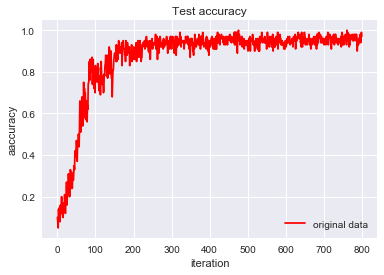

In [130]:
draw_stats([stats], ['original data'], 'Test accuracy')

## Test on augmented data (shifted, rotated, scaled)

In [131]:
new_stats = []
ppl_test_shift = mnistset.test.pipeline() \
                              .load(src=src, fmt='ndarray') \
                              .shift_flattened_pic() \
                              .random_rotate(p=1, angle=(-10, 10), preserve_shape=True) \
                              .random_scale(p=1, factor=(.8, 1.2)) \
                              .update_stats(sess, new_stats, lr_history)

In [132]:
for i in tqdm(range(400)):
    ppl_test_shift.next_batch(100, n_epochs=None)

Predictably we see that our net badly predicts augmented data

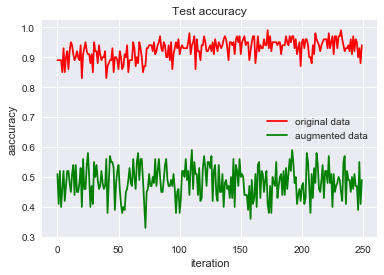

In [134]:
draw_stats([stats[150:400], new_stats[150:400]], ['original data', 'augmented data'], 'Test accuracy')

Let's see some examples where the net makes mistakes:

In [135]:
pics = []
y_true = []
y_predict = []
probs = []

ppl_results = mnistset.test.pipeline() \
                           .load(src=src, fmt='ndarray') \
                           .shift_flattened_pic() \
                           .random_rotate(p=1, angle=(-10, 10), preserve_shape=True) \
                           .random_scale(p=1, factor=(.8, 1.2)) \
                           .predict(sess, pics, y_true, y_predict, probs)

In [136]:
ppl_results.next_batch(100, n_epochs=None)

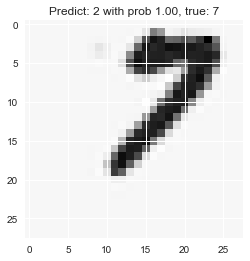

In [138]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

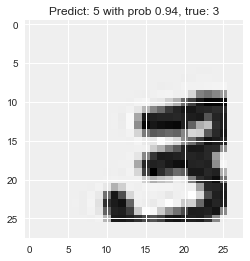

In [147]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

## Let's train on augmented data

In [148]:
# pipeline for train
ppl_shift = mnistset.train.pipeline() \
                          .load(src=src, fmt='ndarray') \
                          .shift_flattened_pic() \
                          .random_rotate(p=1, angle=(-10, 10), preserve_shape=True) \
                          .random_scale(p=1, factor=(.8, 1.2)) \
                          .train_convy(sess)

In [149]:
for i in tqdm(range(1000)):
    ppl_shift.next_batch(100, n_epochs=None)
    ppl_test_shift.next_batch(100, n_epochs=None)

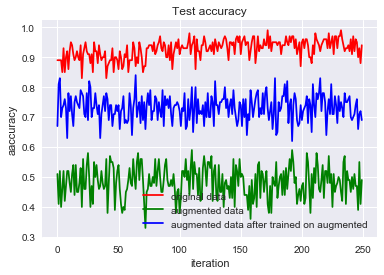

In [150]:
draw_stats([stats[150:400], new_stats[150:400], new_stats[-250:]], ['original data', 'augmented data', 'augmented data after trained on augmented'], \
           'Test accuracy')

In [151]:
pics = []
y_true = []
y_predict = []
probs = []
ppl_results = mnistset.test.pipeline() \
                           .load(src=src, fmt='ndarray') \
                           .shift_flattened_pic() \
                           .random_rotate(p=1, angle=(-10, 10), preserve_shape=True) \
                           .random_scale(p=1, factor=(.8, 1.2)) \
                           .predict(sess, pics, y_true, y_predict, probs)

In [152]:
ppl_results.next_batch(100, n_epochs=None)

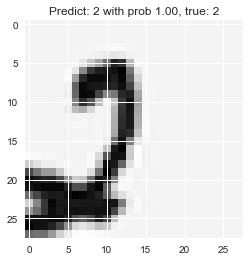

In [162]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

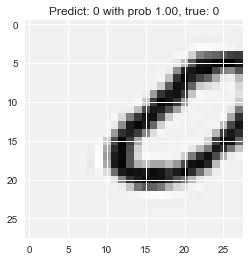

In [156]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

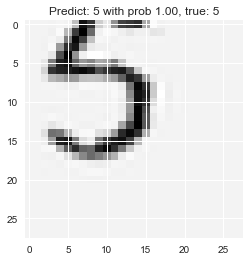

In [169]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

But we still have a space for improvement:

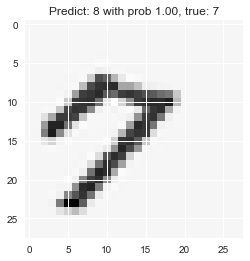

In [179]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

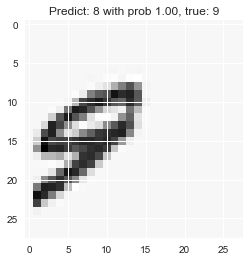

In [180]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

In [181]:
print('Test accuracy on the original data: %.2f %%' % (100.0*np.mean(stats)))
print('Test accuracy on the augmented data: %.2f %%' % (100.0*np.mean(new_stats[:400])))
print('Test accuracy on the augmented data after trained on the augmented data: %.2f %%' % (100.0*np.mean(new_stats[-400:])))

Test accuracy on the original data: 87.02 %
Test accuracy on the augmented data: 48.50 %
Test accuracy on the augmented data after trained on the augmented data: 72.71 %
